# Household Pulse Data Analysis

This analysis examines Long Covid (L.C.) prevalence across U.S. states and the District of Columbia, based on data from the U.S. Centers for Disease Control and Prevention (CDC) as of February 2024. We will explore potential predictors of L.C. rates and investigate statistical relationships between these factors. The dataset was curated by Julia Moore Vogel, and this analysis was conducted by Ashley Yaner. As advised by Julia Vogel, Baysian Variable selection, a statistical method used to identify the most relevant predictors or variables in a dataset, will be used to understand the most prevelant factors contributing to the rates of COVID per state. ---> Wordage similar to Bobby's

# Imports

Import packages

In [441]:
# !pip install pymc
# !pip install arviz --upgrade

In [2]:
import pandas as pd
import re
import numpy as np
import datetime

# For plotting
import seaborn as sns  
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

 # For dendrogram
import scipy.stats as stats
import scipy.cluster.hierarchy as shc 

# For Baysean variable selection
import pymc as pm
from sklearn.impute import SimpleImputer
import arviz as az

# For inspecting and saving inference results
import xarray as xr
import json

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 

In [4]:
pm.__version__

'5.16.2'

# Configs

Path to the household pulse data csv

In [6]:
# houshold_pulse_path = "LC_household_pulse_for_BV_10.csv"
houshold_pulse_path = "LC_household_pulse_v10.csv"

# Load Data

In [7]:
def load_data(
    data_path: str
) -> pd.DataFrame:
    """Loads a CSV file into a pandas DataFrame.

    Args:
        data_path (str):
            The path to the CSV file to be loaded.

    Returns:
        df (pd.DataFrame):
            A pandas DataFrame containing the data from the
            loaded CSV file.

    Raises:
        FileNotFoundError: If the specified `data_path` does
        not exist.
    
    Typical Usage Example: 
        Load in a csv file with columnar data. 
        
        df = load_data("root/path_to_your_data/your_data.csv")  
    """

    try:
        df = pd.read_csv(data_path)
        
    except FileNotFoundError:
        print("Error: Check your file path. File not found at path:", data_path)
        raise
        
    return df

Import the houshold pulse data using pandas dataframe. 

In [8]:
df = load_data(houshold_pulse_path)

Inspect household pulse data dataframe. What does it contain?

In [9]:
df.head(10)

,State,Aug 24 Value,Aug 24 Low CI,Aug 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,White,Black,AI_AN,Asian,NHPI,Hispanic,Multiple,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Eviction moratoria duration,44753,44781,44830,44851,44879,44914,44942,44970,44998,45026,45054,45096,45117,45145,45173,45201,45229,45327,45355,45383,45411,45439,45467,45495,45523,Avg,std_error
0,Alabama,7.6,5.0,10.9,57.7,42.3,50.0,29.0,12.0,8.0,99.0,16.5,0.647117,0.264309,0.005532,0.015477,0.000526,0.041489,0.025550,65.1,7.7,56.6,74.2,63.3,85.3,0.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.480000,0.269691
1,Alaska,8.0,4.6,12.6,64.9,35.1,34.0,37.0,23.0,6.0,100.0,11.4,0.587953,0.032379,0.148749,0.065232,0.015896,0.052876,0.096915,73.2,14.2,69.8,82.9,75.9,89.5,0.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,7.016000,0.329327
2,Arizona,7.4,5.0,10.4,89.3,10.7,39.0,31.0,23.0,7.0,100.0,12.6,0.529302,0.047562,0.037277,0.036369,0.001968,0.289346,0.058177,78.4,15.8,70.2,86.9,75.2,90.8,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,6.824000,0.237506
3,Arkansas,7.6,4.9,11.2,55.5,44.5,42.0,38.0,14.0,6.0,100.0,16.8,0.709676,0.153314,0.007915,0.017788,0.004217,0.075664,0.031426,70.1,11.0,60.6,79.5,66.8,84.2,0.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,7.316000,0.287326
4,California,4.5,3.5,5.6,94.2,5.8,31.0,34.0,29.0,6.0,100.0,12.1,0.347300,0.055794,0.004067,0.155872,0.003738,0.360048,0.073181,85.1,20.6,79.1,94.0,83.9,93.2,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,5.820000,0.229637
5,Colorado,5.4,3.9,7.2,86.0,14.0,33.0,34.0,28.0,5.0,100.0,9.2,0.664714,0.041292,0.006301,0.035518,0.001557,0.197086,0.053532,84.0,22.1,77.7,92.2,82.9,95.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,6.560000,0.242074
6,Connecticut,4.6,2.9,7.0,86.3,13.7,33.0,36.0,25.0,6.0,100.0,9.9,0.638607,0.107293,0.002250,0.050398,0.000377,0.144991,0.056084,95.0,25.6,87.1,95.0,91.7,95.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,6.184000,0.222537
7,Delaware,4.2,2.4,6.9,82.6,17.4,26.0,40.0,25.0,9.0,100.0,8.7,0.599941,0.224680,0.003000,0.042835,0.000346,0.080055,0.049143,88.5,21.2,77.6,95.0,83.2,95.0,0.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,5.858333,0.282709
8,District of Columbia,3.1,1.4,5.7,100.0,0.0,15.0,39.0,36.0,10.0,100.0,13.3,0.375333,0.433571,0.002090,0.045114,0.000585,0.087142,0.056165,95.0,32.1,95.0,95.0,95.0,95.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,3.527273,0.191958
9,Florida,4.3,3.1,5.8,91.5,8.5,37.0,31.0,24.0,8.0,100.0,12.7,0.523389,0.154157,0.002540,0.030022,0.000683,0.244639,0.044570,82.9,11.7,73.5,92.5,79.6,94.4,0.0,182.0,7.2,9.1,6.9,4.8,6.3,4.5,5.1,4.6,5.8,4.6,4.3,4.6,5.9,5.3,4.7,5.6,5.0,6.3,6.7,6.4,4.8,5.5,5.3,4.2,4.3,5.512000,0.229878


# Remove specific columns

In [10]:
def remove_columns(
    df:pd.DataFrame,
    columns_to_remove:list
) -> pd.DataFrame:
    """Removes specific columns from dataframe. 

    Args:
        df (pd.DataFrame):
            A pandas DataFrame.
            
        columns_to_remove (list):
            A list of columns names to remove from the dataframe.
            
    Returns:
        df_new (pd.DataFrame):
            A pandas DataFrame with specified columns removed.
    
    Typical Usage Example: 
        If one suspects that certain columns have bias in their 
        collection or are  duplicative or have other issues, 
        use this function to remove those columns from the 
        dataframe so that they are excluded from further
        analysis.
        
        df_new = remove_columns(df) 
    """
    
    df_new = df.drop(columns=columns_to_remove)

    return df_new

Remove race data from the Long Covid dataframe because it seems that there could be a bias in it's collection

In [11]:
columns_to_remove = ['White', 'Black', 'AI_AN', 'Asian', 'NHPI', 'Hispanic', 'Multiple']

In [13]:
df_no_race = remove_columns(df, columns_to_remove) 

# Set States as Index

In [14]:
def set_states_as_idx(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Preprocesses a CSV file containing state-level data.
    
    Sets row names to values in the "State" column. Then, filters data
    to exclude rows where state column equals "United States".

    Args:
        df (pd.DataFrame):
            A pandas DataFrame containing the data from the
            loaded CSV file.

    Returns:
        df_states (pd.DataFrame):
            A preprocessed DataFrame with state names as row indices.

    Typical Usage Example: 
        This function is useful for preparing state-level data for
        analysis by:
            * Setting state names as row indices for easy identification
                and indexing.
            * Removing data for the United States if it's not relevant
                to your analysis.
            * Removing the "State" column to avoid redundancy.
            
        df_states= set_states_as_idx(df)

    The preprocessed DataFrame can then be used for various tasks, such
    as calculating statistics, creating visualizations, or performing
    machine learning models.
    """
    
    # Set state names as row indices
    df_states = df.copy()
    df_states.set_index("State", inplace=True)

    # Remove rows for the United States
    df_states = df_states.loc[df_states.index != "United States"]

    return df_states

In [15]:
df_states= set_states_as_idx(df_no_race)

In [16]:
df_states.head(10)

,Aug 24 Value,Aug 24 Low CI,Aug 24 High CI,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Eviction moratoria duration,44753,44781,44830,44851,44879,44914,44942,44970,44998,45026,45054,45096,45117,45145,45173,45201,45229,45327,45355,45383,45411,45439,45467,45495,45523,Avg,std_error
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,7.6,5.0,10.9,57.7,42.3,50.0,29.0,12.0,8.0,99.0,16.5,65.1,7.7,56.6,74.2,63.3,85.3,0.0,59.0,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6,7.480000,0.269691
Alaska,8.0,4.6,12.6,64.9,35.1,34.0,37.0,23.0,6.0,100.0,11.4,73.2,14.2,69.8,82.9,75.9,89.5,0.0,114.0,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0,7.016000,0.329327
Arizona,7.4,5.0,10.4,89.3,10.7,39.0,31.0,23.0,7.0,100.0,12.6,78.4,15.8,70.2,86.9,75.2,90.8,1.0,0.0,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4,6.824000,0.237506
Arkansas,7.6,4.9,11.2,55.5,44.5,42.0,38.0,14.0,6.0,100.0,16.8,70.1,11.0,60.6,79.5,66.8,84.2,0.0,0.0,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6,7.316000,0.287326
California,4.5,3.5,5.6,94.2,5.8,31.0,34.0,29.0,6.0,100.0,12.1,85.1,20.6,79.1,94.0,83.9,93.2,1.0,884.0,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5,5.820000,0.229637
Colorado,5.4,3.9,7.2,86.0,14.0,33.0,34.0,28.0,5.0,100.0,9.2,84.0,22.1,77.7,92.2,82.9,95.0,1.0,117.0,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4,6.560000,0.242074
Connecticut,4.6,2.9,7.0,86.3,13.7,33.0,36.0,25.0,6.0,100.0,9.9,95.0,25.6,87.1,95.0,91.7,95.0,1.0,740.0,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6,6.184000,0.222537
Delaware,4.2,2.4,6.9,82.6,17.4,26.0,40.0,25.0,9.0,100.0,8.7,88.5,21.2,77.6,95.0,83.2,95.0,0.0,205.0,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2,5.858333,0.282709
District of Columbia,3.1,1.4,5.7,100.0,0.0,15.0,39.0,36.0,10.0,100.0,13.3,95.0,32.1,95.0,95.0,95.0,95.0,1.0,894.0,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1,3.527273,0.191958


# Extract Long COVID Rates

In [17]:
def extract_lc_rates(
    df: pd.DataFrame,
    col_pattern: str
) -> pd.Series:
    """Extracts the Long COVID rate columns from a pandas DataFrame.

    Args:
        df (pd.DataFrame):
            The input DataFrame containing the household
            pulse data.
            
        col_pattern (str):
            A regular expression pattern for matching column names.

    Returns:
        lc_rates (pd.Series):
            A Series containing the extracted Long COVID rate data.
            
    Typical Usage Example: 
        This function is useful for extracting specific columns from
        a DataFrame based on a regular expression pattern. It can be
        used to isolate Long COVID rate data from a dataset for further
        analysis or visualization.
    
        lc_rates = extract_lc_rates(df_states, "^[0-9]+$")
        
            ^ Matches the beginning of the string.
            [0-9]+ Matches one or more digits (0-9).
            $ Matches the end of the string.
    """

    lc_rates_idx = [
        i for i,
        col in enumerate(df.columns) if re.match(col_pattern, col)
    ]
    
    lc_rates = df.iloc[:, lc_rates_idx]
    
    return lc_rates

In [18]:
# lc_rates = extract_lc_rates(df_states, "^X[0-9]+\\.[0-9]+\\.[0-9]+$")
lc_rates = extract_lc_rates(df_states, "^[0-9]+$")

In [19]:
lc_rates

,44753,44781,44830,44851,44879,44914,44942,44970,44998,45026,45054,45096,45117,45145,45173,45201,45229,45327,45355,45383,45411,45439,45467,45495,45523
State,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6
Alaska,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0
Arizona,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4
Arkansas,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6
California,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5
Colorado,7.7,9.3,7.8,8.0,6.1,6.6,5.4,7.8,6.1,6.1,7.6,6.4,6.1,6.1,4.7,5.8,5.4,6.4,6.0,9.4,6.1,5.3,6.7,5.7,5.4
Connecticut,7.7,7.7,6.5,5.0,7.5,5.2,7.5,5.9,6.7,8.0,6.5,5.1,4.1,5.8,5.8,7.1,5.3,6.3,6.4,7.7,4.6,5.8,5.5,6.3,4.6
Delaware,3.8,5.1,8.3,5.9,8.2,5.3,8.4,7.3,6.3,5.9,4.3,7.8,5.6,5.7,5.0,4.5,5.3,4.9,5.2,7.3,5.3,4.3,6.7,NaN,4.2
District of Columbia,3.5,6.1,NaN,3.2,3.4,4.1,3.8,3.8,3.2,4.0,2.0,NaN,2.1,3.8,3.7,3.7,NaN,4.5,4.1,4.4,3.2,3.0,2.3,2.6,3.1


In [20]:
def convert_excel_dates(lc_rates):
    dates_converted = []

    # Convert 5-digit column headers to dates and format as strings
    for col in lc_rates.columns:
        excel_date = int(col) - 2  # Excel incorrectly treats 1900 as leap year AND starts at idx 1
        date_datetime = datetime.datetime(1900, 1, 1) + datetime.timedelta(days=excel_date)
        dates_converted.append(date_datetime.strftime('%m-%d-%Y'))

    return dates_converted

In [21]:
dates = convert_excel_dates(lc_rates)

In [22]:
dates

['07-11-2022',
 '08-08-2022',
 '09-26-2022',
 '10-17-2022',
 '11-14-2022',
 '12-19-2022',
 '01-16-2023',
 '02-13-2023',
 '03-13-2023',
 '04-10-2023',
 '05-08-2023',
 '06-19-2023',
 '07-10-2023',
 '08-07-2023',
 '09-04-2023',
 '10-02-2023',
 '10-30-2023',
 '02-05-2024',
 '03-04-2024',
 '04-01-2024',
 '04-29-2024',
 '05-27-2024',
 '06-24-2024',
 '07-22-2024',
 '08-19-2024']

In [23]:
len(dates)

25

## Convert matrix to vector

In [24]:
def matrix_to_vector(
    df: pd.DataFrame
) -> pd.Series:
    # Flatten dataframe. 
    lc_rates_flat = lc_rates.melt(ignore_index=False)['value']
    
    return lc_rates_flat

In [25]:
lc_rates_flat = matrix_to_vector(lc_rates)
print(lc_rates.shape)
print(len(lc_rates_flat))
print(f"lc_rates_flat min: {lc_rates_flat.min()}, {lc_rates_flat.max()}")

(51, 25)
1275
lc_rates_flat min: 2.0, 16.5


In [26]:
lc_rates_flat['Alabama']

State
Alabama     9.0
Alabama    11.2
Alabama     7.6
Alabama     8.0
Alabama     9.0
Alabama     6.8
Alabama     7.3
Alabama     5.7
Alabama     7.6
Alabama     7.3
Alabama     5.5
Alabama     7.7
Alabama     6.7
Alabama     7.1
Alabama     6.3
Alabama     8.8
Alabama     6.8
Alabama     7.9
Alabama     8.3
Alabama     7.4
Alabama     8.3
Alabama     8.6
Alabama     5.0
Alabama     5.5
Alabama     7.6
Name: value, dtype: float64

# Normalize

## Compute Zscore

In [27]:
def compute_zscore_df(
    df: pd.DataFrame
) -> pd.DataFrame:
    """Computes the z-score for all columns in a pandas DataFrame
  
    Args:
        df (pd.DataFrame):
            A pandas DataFrame.

    Returns:
        df_z_score (pd.DataFrame): 
            A new pandas DataFrame with the z-scores of each column.

          
    Typical Usage Example:
    
        Take a DataFrame and a column name as input, calculate the mean
        and standard deviation of the specified column, and return a new
        pandas Series containing the z-scores. This allows you to easily
        apply the z-score calculation to specific columns within your
        DataFrame.    
        
        df_z_scores =  compute_zscore_df(df)
  """

    # Select numeric columns only
    numeric_df = df.select_dtypes(include=[np.number])

    # Calculate mean and standard deviation for numeric columns
    df_means = numeric_df.mean(skipna=True)
    df_stds = numeric_df.std(skipna=True)

    # Calculate z-scores for numeric columns
    z_scores = (df[numeric_df.columns] - df_means) / df_stds

    # Fill missing values in z-scores with NaN
    z_scores = z_scores.fillna(np.nan)

    # Combine z-scores with original DataFrame
    # result_df = pd.concat([df, z_scores], axis=1)

    return z_scores

def compute_zscore_np(
    data: np.ndarray
) -> np.ndarray:
    """Computes the z-score for a NumPy array.

    Args:
        data (np.ndarray):
            A NumPy array.

    Returns:
        z_scores (np.ndarray):
            A NumPy array containing the z-scores of the input data.
    """
    # Remove NA values
    data = data[~np.isnan(data)]
    
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std

    return z_scores

In [28]:
lc_rates_flat_z_scores = compute_zscore_np(lc_rates_flat)

In [29]:
lc_rates_flat_z_scores.head(20)

State
Alabama                 1.639552
Alaska                  1.451318
Arizona                 2.016020
Arkansas                1.576807
California              0.384658
Colorado                0.823871
Connecticut             0.823871
Delaware               -1.623170
District of Columbia   -1.811404
Florida                 0.510148
Georgia                 0.133680
Hawaii                 -2.187872
Idaho                   2.580721
Illinois                1.200339
Indiana                 0.133680
Iowa                    2.078764
Kansas                  0.259169
Kentucky                2.266998
Louisiana               0.698382
Maine                   0.447403
Name: value, dtype: float64

In [30]:
def create_qq_plot(
    data: pd.Series
) -> None:
    """Creates a Q-Q plot of the specified Long COVID rate data.

    Args:
        lc_rates (pd.Series):
            A pandas Series containing the Z-Score of the 
            Long COVID rate data.

    Returns:
        None: The function directly creates the plot.
    """

    theoretical_quantiles = stats.norm.ppf(stats.rankdata(data) / (len(data) + 1))

    print(f"theoretical_quantiles min: {theoretical_quantiles.min()}, "\
          f"max: {theoretical_quantiles.max()}")
    print(f"data min: {data.min()}, max: {data.max()}")
    print(f"len(data): {len(data)}")
    
    plt.figure(figsize=(7, 7))

    # Add QQ line and data
    stats.probplot(data, dist="norm", plot=plt)
    
    # Access the scatter plot created by probplot
    scatter_plot = plt.gca().get_children()[0]
    
    # Modify the scatter plot properties
    scatter_plot.set_marker('o')  # Set marker to circles
    scatter_plot.set_markeredgecolor('black')  # Set edge color to black
    scatter_plot.set_markerfacecolor('white')  # Set face color to white for hollow
    scatter_plot.set_markersize(4)  # Adjust the marker size as needed

    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title("Normal Q-Q Plot")
    plt.grid(False)
    
    plt.show()

theoretical_quantiles min: -3.1593844753994285, max: 3.1593844753994302
data min: -2.752574303950324, max: 6.345400816931454
len(data): 1264


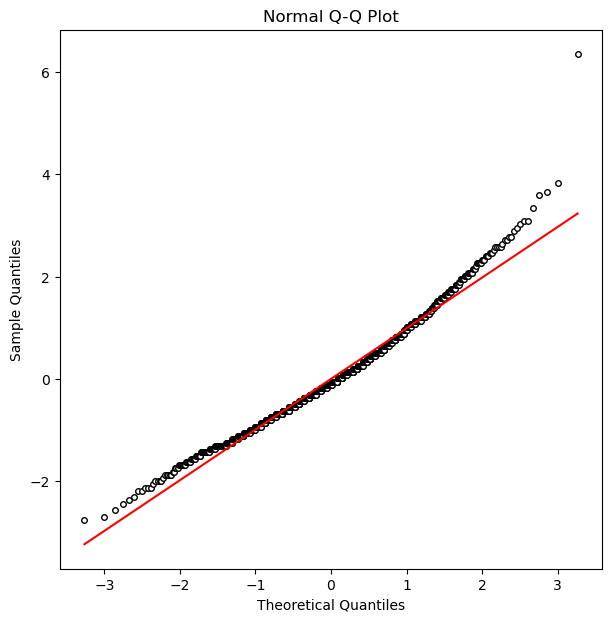

In [31]:
create_qq_plot(lc_rates_flat_z_scores)

In [32]:
lc_rates = lc_rates.set_axis(dates, axis=1)

In [33]:
lc_rates.head()

,07-11-2022,08-08-2022,09-26-2022,10-17-2022,11-14-2022,12-19-2022,01-16-2023,02-13-2023,03-13-2023,04-10-2023,05-08-2023,06-19-2023,07-10-2023,08-07-2023,09-04-2023,10-02-2023,10-30-2023,02-05-2024,03-04-2024,04-01-2024,04-29-2024,05-27-2024,06-24-2024,07-22-2024,08-19-2024
State,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,9.0,11.2,7.6,8.0,9.0,6.8,7.3,5.7,7.6,7.3,5.5,7.7,6.7,7.1,6.3,8.8,6.8,7.9,8.3,7.4,8.3,8.6,5.0,5.5,7.6
Alaska,8.7,7.9,8.1,8.8,8.1,5.5,4.9,5.4,4.9,5.3,9.9,5.2,8.3,7.7,9.1,4.5,5.4,9.2,7.7,8.2,5.7,6.8,6.7,5.4,8.0
Arizona,9.6,10.1,6.2,7.9,7.3,6.1,5.9,6.9,7.6,7.0,6.4,8.3,6.4,6.3,6.9,6.2,5.9,6.3,6.4,6.4,5.4,5.9,6.9,4.9,7.4
Arkansas,8.9,7.2,9.1,10.5,9.1,6.8,8.0,6.4,6.2,8.9,9.7,6.9,5.7,6.5,5.2,5.9,6.7,8.0,6.5,6.1,5.3,6.6,6.6,8.5,7.6
California,7.0,8.7,6.3,7.7,6.8,5.8,5.3,5.8,5.5,5.4,4.7,5.8,4.7,4.9,4.8,4.8,5.5,6.8,7.2,7.2,4.7,5.3,4.1,6.2,4.5


In [34]:
lc_rates.columns

Index(['07-11-2022', '08-08-2022', '09-26-2022', '10-17-2022', '11-14-2022',
       '12-19-2022', '01-16-2023', '02-13-2023', '03-13-2023', '04-10-2023',
       '05-08-2023', '06-19-2023', '07-10-2023', '08-07-2023', '09-04-2023',
       '10-02-2023', '10-30-2023', '02-05-2024', '03-04-2024', '04-01-2024',
       '04-29-2024', '05-27-2024', '06-24-2024', '07-22-2024', '08-19-2024'],
      dtype='object')

In [40]:
def dendrogram(data):
    
    # Calculate the linkage matrix
    distance_matrix = shc.distance.pdist(data)  # Use pairwise distances
    linkage_matrix = shc.linkage(distance_matrix, method='ward')

    # Create the figure with a smaller size
    fig = plt.figure(figsize=(10, 7))
    # Create a gridspec layout
    gs = gridspec.GridSpec(
        1,
        2,
        width_ratios=[15, 85],
        figure=fig,
        wspace=0
    )

    axs = gs.subplots(sharex='col')
        
    # Create the dendrogram
    # axs[0] = plt.subplot(gs[0])
    dendrogram = shc.dendrogram(
        linkage_matrix,
        orientation='left',
        no_labels=True,
        ax=axs[0]
    )
    
    # Plot heatmap
    # axs[1] = plt.subplot(gs[1], sharex=ax1)
    
    data_index = data.index
    data_col_names = data.columns
    
    # Remove "State" from idx
    data = data.reset_index(drop=True)
    
    axs[1] = sns.heatmap(
        data,
        cbar=True,  # Display colorbar
        cmap="Reds",  # Choose a colormap (adjust as needed)
        linewidths=0.0,  # No lines between cells
        xticklabels=True,  # Show x-axis labels
        yticklabels=False  # Don't show y-axis labels
    )
    
    # Add y-axis labels to the right
    # Set the y-axis ticks and labels for ax[1]
    axs[1].set_yticks(range(len(data)))
    axs[1].set_yticklabels(data_index)

    # Set the y-axis ticks and labels for ax[1]
    axs[1].set_xticks(range(len(data_col_names)))
    axs[1].set_xticklabels(data_col_names)

    # Adjust the y-axis position for ax[1]
    axs[1].yaxis.tick_right()

    axs[1].tick_params(axis="y", left = False, labelleft=False) 
    
    plt.show()


In [41]:
print(f"Is NaN: {np.isnan(lc_rates_flat_z_scores).any()}")  # Checks for NaNs
print(f"Is INF: {np.isinf(lc_rates_flat_z_scores).any()}")  # Checks for infinities
print(f"Has Zeros: {(lc_rates_flat_z_scores == 0).any()}")  # Checks for infinities
print(lc_rates_flat_z_scores.dtype)

Is NaN: False
Is INF: False
Has Zeros: False
float64


In [42]:
lc_rates_zscore = compute_zscore_df(lc_rates)

In [43]:
# print(f"Is NaN: {np.isnan(lc_rates_zscore).any()}")  # Checks for NaNs
# print(f"Is INF: {np.isinf(lc_rates_zscore).any()}")  # Checks for infinities
# print(f"Has Zeros: {(lc_rates_zscore == 0).any()}")  # Checks for infinities

In [44]:
lc_rates_zscore.fillna(lc_rates_zscore.mean(), inplace=True)

In [45]:
lc_rates_zscore.index.nlevels

1

In [46]:
lc_rates_zscore.head()

,07-11-2022,08-08-2022,09-26-2022,10-17-2022,11-14-2022,12-19-2022,01-16-2023,02-13-2023,03-13-2023,04-10-2023,05-08-2023,06-19-2023,07-10-2023,08-07-2023,09-04-2023,10-02-2023,10-30-2023,02-05-2024,03-04-2024,04-01-2024,04-29-2024,05-27-2024,06-24-2024,07-22-2024,08-19-2024
State,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0.668492,2.113911,0.014515,0.471193,1.611858,0.999512,0.727689,-0.296009,0.684017,0.645814,-0.360489,0.954582,0.548217,0.708582,0.347730,2.070280,1.294332,0.588441,1.212185,0.245276,1.681910,1.979963,-0.494052,-0.248889,0.957474
Alaska,0.508566,0.254661,0.268529,0.904182,0.861510,-0.415919,-0.946543,-0.498194,-0.904333,-0.818030,2.538931,-0.807940,1.875649,1.167960,2.434108,-0.742684,-0.210705,1.406338,0.764204,0.815687,-0.076933,0.611284,0.689216,-0.323856,1.184123
Arizona,0.988345,1.494161,-0.696724,0.417070,0.194535,0.237357,-0.248946,0.512731,0.684017,0.426237,0.232574,1.377587,0.299323,0.096079,0.794811,0.369418,0.326808,-0.418200,-0.206423,-0.467736,-0.279876,-0.073056,0.828425,-0.698689,0.844150
Arkansas,0.615184,-0.139725,0.776557,1.824282,1.695229,0.999512,1.216007,0.175756,-0.139572,1.816889,2.407139,0.390575,-0.281429,0.249205,-0.471919,0.173165,1.186829,0.651357,-0.131759,-0.681640,-0.347524,0.459208,0.619612,2.000108,0.957474
California,-0.397684,0.705388,-0.645921,0.308823,-0.222325,-0.089281,-0.667504,-0.228614,-0.551366,-0.744838,-0.887657,-0.384935,-1.111074,-0.975802,-0.769973,-0.546431,-0.103203,-0.103625,0.390886,0.102674,-0.753411,-0.529282,-1.120489,0.275877,-0.799052


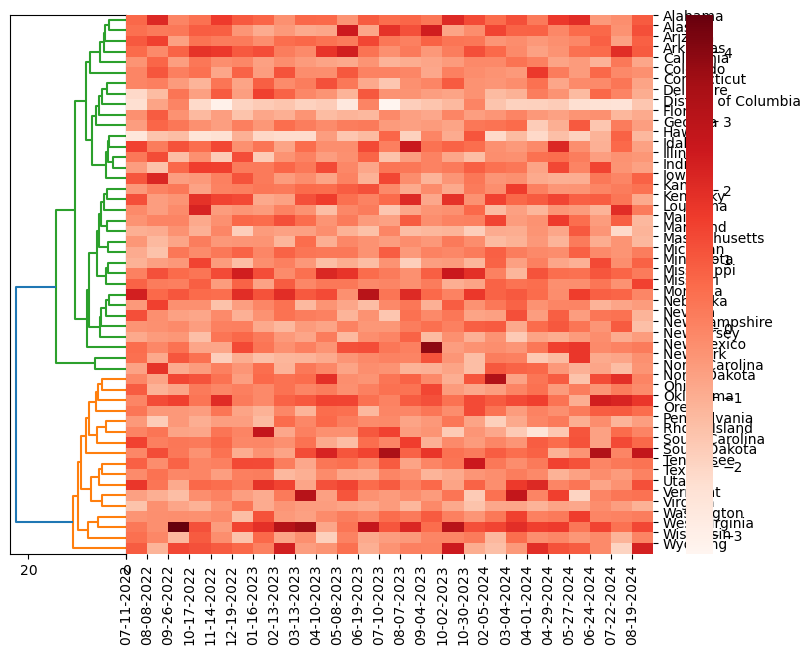

In [47]:
# TODO - MAKE PLOT PRETTIER BY MOVING COLORBAR !!!!!!!!!!!!!!!!!
dendrogram(lc_rates_zscore)

In [49]:
def get_variables_df(df, list_of_cols_to_remove, pattern="^[0-9]+$"):
    """ Gets variables from dataframe which may or may not
    contribute to the Long COVID rates.
    """
    # Exclude all columns which match the pattern
    exclude_mask = df.columns.astype(str).str.contains(pattern)
    
    # Filter columns based on the exclude mask
    df_filtered = df.loc[:, ~exclude_mask]
    
    # df_filtered = df_filtered.drop(columns=['Avg', 'Jul 24 Value', 'Jul 24 Low CI', 'Jul 24 High CI'])
    # df_filtered = df_filtered.drop(columns=['Avg', 'Aug 24 Value', 'Aug 24 Low CI', 'Aug 24 High CI', 'std_error'])
    df_filtered = df_filtered.drop(columns=list_of_cols_to_remove)

    return df_filtered

In [50]:
list_of_cols_to_remove = ['Avg', 'Aug 24 Value', 'Aug 24 Low CI', 'Aug 24 High CI', 'std_error']
df_variables = get_variables_df(df_states, list_of_cols_to_remove, pattern="^[0-9]+$")

In [51]:
df_variables.head()

,Urban,Rural,Conservative,Moderate,Liberal,Political Don't know,Political sum,Below Poverty Line,Percent of total pop with at least one dose,Percent of pop with an updated (bivalent) booster dose,Percent of 5+ pop with a completed primary series,Percent of 12+ pop with at least one dose,Percent of 18+ pop with a completed primary series,Percent of 65+ pop with a completed primary series,Paid sick leave,Eviction moratoria duration
State,,,,,,,,,,,,,,,,
Alabama,57.7,42.3,50.0,29.0,12.0,8.0,99.0,16.5,65.1,7.7,56.6,74.2,63.3,85.3,0.0,59.0
Alaska,64.9,35.1,34.0,37.0,23.0,6.0,100.0,11.4,73.2,14.2,69.8,82.9,75.9,89.5,0.0,114.0
Arizona,89.3,10.7,39.0,31.0,23.0,7.0,100.0,12.6,78.4,15.8,70.2,86.9,75.2,90.8,1.0,0.0
Arkansas,55.5,44.5,42.0,38.0,14.0,6.0,100.0,16.8,70.1,11.0,60.6,79.5,66.8,84.2,0.0,0.0
California,94.2,5.8,31.0,34.0,29.0,6.0,100.0,12.1,85.1,20.6,79.1,94.0,83.9,93.2,1.0,884.0


In [52]:
len(df_variables.columns)

16

In [53]:
def get_values_df(df1, df_values, col_to_add="Avg"):
    """ Adds the avg column back onto the lc_rates dataframe, 
    which contains all of the dates.
    """
    
    df_combined = pd.concat([df1[col_to_add], df_values], axis=1)
    
    return df_combined
    

In [59]:
lc_rates = get_values_df(df_states, lc_rates_zscore)
lc_rates.head(10)

,Avg,07-11-2022,08-08-2022,09-26-2022,10-17-2022,11-14-2022,12-19-2022,01-16-2023,02-13-2023,03-13-2023,04-10-2023,05-08-2023,06-19-2023,07-10-2023,08-07-2023,09-04-2023,10-02-2023,10-30-2023,02-05-2024,03-04-2024,04-01-2024,04-29-2024,05-27-2024,06-24-2024,07-22-2024,08-19-2024
State,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,7.480000,0.668492,2.113911,1.451508e-02,0.471193,1.611858,0.999512,0.727689,-0.296009,0.684017,0.645814,-0.360489,9.545816e-01,0.548217,0.708582,0.347730,2.070280,1.294332e+00,0.588441,1.212185,0.245276,1.681910,1.979963,-0.494052,-2.488890e-01,0.957474
Alaska,7.016000,0.508566,0.254661,2.685290e-01,0.904182,0.861510,-0.415919,-0.946543,-0.498194,-0.904333,-0.818030,2.538931,-8.079398e-01,1.875649,1.167960,2.434108,-0.742684,-2.107052e-01,1.406338,0.764204,0.815687,-0.076933,0.611284,0.689216,-3.238556e-01,1.184123
Arizona,6.824000,0.988345,1.494161,-6.967239e-01,0.417070,0.194535,0.237357,-0.248946,0.512731,0.684017,0.426237,0.232574,1.377587e+00,0.299323,0.096079,0.794811,0.369418,3.268081e-01,-0.418200,-0.206423,-0.467736,-0.279876,-0.073056,0.828425,-6.986885e-01,0.844150
Arkansas,7.316000,0.615184,-0.139725,7.765568e-01,1.824282,1.695229,0.999512,1.216007,0.175756,-0.139572,1.816889,2.407139,3.905747e-01,-0.281429,0.249205,-0.471919,0.173165,1.186829e+00,0.651357,-0.131759,-0.681640,-0.347524,0.459208,0.619612,2.000108e+00,0.957474
California,5.820000,-0.397684,0.705388,-6.459211e-01,0.308823,-0.222325,-0.089281,-0.667504,-0.228614,-0.551366,-0.744838,-0.887657,-3.849347e-01,-1.111074,-0.975802,-0.769973,-0.546431,-1.032026e-01,-0.103625,0.390886,0.102674,-0.753411,-0.529282,-1.120489,2.758770e-01,-0.799052
Colorado,6.560000,-0.024522,1.043434,1.161206e-01,0.471193,-0.805929,0.781753,-0.597745,1.119286,-0.198400,-0.232493,1.023325,3.807046e-02,0.050429,-0.057047,-0.844487,0.107747,-2.107052e-01,-0.355285,-0.505077,1.671302,0.193658,-0.529282,0.689216,-9.895588e-02,-0.289093
Connecticut,6.184000,-0.024522,0.141979,-5.443155e-01,-1.152513,0.361278,-0.742557,0.867209,-0.161219,0.154567,1.158159,0.298470,-8.784406e-01,-1.608861,-0.286736,-0.024838,0.958178,-3.182079e-01,-0.418200,-0.206423,0.459180,-0.821058,-0.149094,-0.146032,3.508436e-01,-0.742390
Delaware,5.858333,-2.103565,-1.322885,3.701346e-01,-0.665401,0.944882,-0.633678,1.495046,0.782311,-0.080744,-0.378877,-1.151241,1.025082e+00,-0.364393,-0.363299,-0.620946,-0.742684,-3.182079e-01,-1.299012,-1.102386,0.173975,-0.347524,-1.289660,0.689216,-5.417888e-16,-0.969038
District of Columbia,3.527273,-2.263492,-0.759476,9.063045e-17,-2.126737,-3.056971,-1.940229,-1.713899,-1.576514,-1.904405,-1.769529,-2.666847,-6.217249e-17,-3.268151,-1.817994,-1.589622,-1.266026,9.103829e-16,-1.550673,-1.923685,-1.893762,-1.768128,-2.278150,-2.373361,-2.422920e+00,-1.592322


In [60]:
def bayesian_variable_selection_with_dfs(
    df_vars: pd.DataFrame,
    series_values: pd.Series,
    target_col: str, 
    model_params: dict
) -> pm.backends.base.MultiTrace:
    """Performs Bayesian Variable Selection using PyMC3
    on a pandas DataFrame containing variables and a pandas
    Series containing Long COVID rates.

    Args:
      df_vars (pandas.DataFrame):
          DataFrame containing variables afftecting/not
          affecting Long COVID Rates.
          
      series_values (pd.Series):
          DataFrame containing Long COVID rates.
          
      target_col (str):
          The column name of the target column in df_values. 
          This can contains either a specific date or avg of 
          all dates of Long COVID rates.
          
      model_params (dict):
          Dictionary of model parameters.
          
    Returns:
      trace (pm.backends.base.MultiTrace):
          A PyMC3 trace object containing the Baysian Variable
          Selection results.
    """
    # Extract data from DataFrames
    y = series_values.values  # Long COVID rates
    X = df_vars.values  # Variables affecting/not affecting LC rates

    # Impute missing values using SimpleImputer.
    # Replace 'mean' with 'median' or 'most_frequent' if needed
    imputer = SimpleImputer(strategy='mean')  
    X_imputed = imputer.fit_transform(X)    
    
    n, p = X.shape

    with pm.Model() as model:
        # ------------------------------------------------------------------------------
        # Priors
        # ------------------------------------------------------------------------------
        # sigma defines a prior distribution for the std of the noise term in 
        # the model. It uses a half-Cauchy distribution with a scale parameter
        # beta=1. This distribution is heavy-tailed, meaning it allows for a
        # wide range of possible values for the std, reflecting uncertainty
        # about the noise level. A beta parameter of 1 indicates a relatively
        # flat prior, meaning it doesn't strongly favor any particular scale of
        # the distribution. This is often desirable when we have limited prior
        # knowledge or want to let the data drive the inference.
        sigma = pm.HalfCauchy('sigma', beta=model_params["beta"])
        # beta_raw defines a prior distribution for a vector of raw coefficients 
        # associated with each feature in the data. It uses a normal distribution
        # with a mean of 0 and a std of 1 for each element of beta_raw. A mean of
        # 0 indicates a neutral prior, meaning it doesn't favor any particular
        # value of the parameter. Setting std to 1 means the prior distribution
        # is scale-invariant, meaning the choice of units doesn't affect the
        # inference. The shape=p argument specifies that beta_raw will be a vector of 
        # length p, where p is the number of features in your data.
        beta_raw = pm.Normal(
            'beta_raw',
            mu=model_params["mu"],
            sigma=model_params["sigma"],
            shape=p
        )
        # ind defines a prior distribution for a vector of indicator variables
        # for each feature. It uses a Bernoulli distribution with a probability of
        # success (p=0.2) for each element of ind. This means there's a 20% chance for
        # each element to be 1 (indicating inclusion) and an 80% chance to be 0
        # (exclusion). Setting p=0.2 can be seen as a sparsity assumption, a form of 
        # regularization, of for use in computational efficiency. Rgarding the sparsity
        # assumption, many real-world problems exhibit sparsity, meaning only a small
        # subset of features are truly informative. Rgarding regularization, setting 
        # p=0.2, the model is encouraged to favor simpler models with fewer active
        # features, which helps prevent overfitting. With respect to computational 
        # efficiency, using a smaller p value can lead to computational efficiency gains,
        # especially in high-dimensional problems, as it reduces the number of features
        # that need to be considered. The shape=p argument ensures ind has the same
        # length as beta_raw.
        ind = pm.Bernoulli('ind', p=model_params["prob_of_success"], shape=p)
        # This defines a deterministic variable (beta) that combines the raw
        # coefficients (beta_raw) and the indicator variables (ind). The element-wise
        # multiplication (*) ensures that features with corresponding ind values of 0
        # get effectively set to 0 in beta. This is how variable selection is achieved
        # through the interaction of priors. Features with low selection probability
        # (low ind values) will have their coefficients shrunk towards 0 in the posterior
        # distribution.
        beta = pm.Deterministic('beta', beta_raw * ind)

        # ------------------------------------------------------------------------------
        # Likelihood
        # ------------------------------------------------------------------------------
        # mu defines a deterministic variable (mu) that represents the predicted mean of
        # the response variable (y).It uses the dot product (pm.math.dot) between the
        # imputed data matrix (X_imputed) and the coefficient vector (beta) to calculate
        # the predicted means for each data point.
        mu = pm.Deterministic('mu', pm.math.dot(X_imputed, beta))
        # likelihood defines the likelihood function, representing the probability of 
        # observing the actual data (y) given the predicted means (mu) and the assumed 
        # noise distribution. It uses a normal distribution with the predicted means
        # (mu) as the expected values and the standard deviation (sigma) from the 
        # prior. The observed data (y) is used to compute the likelihood for each data
        # point.
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)

        # ------------------------------------------------------------------------------
        # Sampling
        # ------------------------------------------------------------------------------
        # This performs Markov chain Monte Carlo (MCMC) sampling using the PyMC3 library.
        # It samples 500 posterior draws from the joint distribution of all model
        # parameters after an initial tuning phase of 100 draws (tune). The cores=4
        # argument (optional) enables parallel sampling using 4 CPU cores, if available,
        # to speed up the process.
        # Trace is is the result of the the MCMC, which contains information about the
        # sampled parameter values after the model has been fit.
        trace = pm.sample(
            draws=model_params["draws"],  # Increased draws for better estimation
            tune=model_params["tune"],  # Increased tuning for better initialization
            cores=model_params["cores"],
            step=[pm.NUTS(target_accept=model_params["target_accept"],
                          max_treedepth=model_params["max_treedepth"])]
        )
        
    return trace

In [61]:
def bayesian_variable_selection_multiple(
    df_vars: pd.DataFrame,
    df_values: pd.DataFrame,
    model_params: dict
) -> list:
    """
    Performs Bayesian Variable Selection for multiple target
    variables in two pandas DataFrames, one containing variables and
    the other containing Long COVID rates (for different dates and also
    an accumulated avg).

    Args:
        df_vars (pandas.DataFrame):
            The input DataFrame containing the variables.
            
        df_values (pandas.DataFrame):
            The input DataFrame containing the Long COVID rates.
            
      model_params (dict):
          Dictionary of model parameters.
          
    Returns:
        traces (list):
            A list of PyMC trace objects, one for each target variable, 
            containing the Baysian Variable Selection results. 
    """

    traces = []  # init list to store results of BVS
    
    # Iterate through columns in Long COVID rate dataframe
    for target_col in df_values.columns:

        trace = bayesian_variable_selection_with_dfs(
            df_vars,  # dataframe containing variables
            df_values[target_col],  # series containing Long COVID rates
            target_col,  # corresponding column header to rate values
            model_params # model parameters for BVS
        )
        
        traces.append(trace)  # append BVS results to list
        
        save_inference_arviz_to_df(trace, f"{target_col}", model_params)
        
    return traces

In [62]:
def save_inference_arviz_to_df(
    inferece_results_az:  az.InferenceData,
    name: str,
    model_params: dict
) -> None:
    
    # Convert inference arviz data type to pandas datafram
    posterior_df  = inferece_results_az.to_dataframe()
    sample_stats_df = inferece_results_az.sample_stats.to_dataframe()
    observed_data_df = inferece_results_az.observed_data.to_dataframe()
    
    # Get current date so that we can keep track of when
    # the inference was run
    now = datetime.datetime.now()
    formatted_date = now.strftime('%m-%d-%Y_%H-%M-%S')
    
    # Save pandas dataframe to csv.
    posterior_df.to_csv(
        f'LC_household_pulse_BVS_posterior_{name}_{formatted_date}.csv',
        index=False
    )
    
    # Save pandas dataframe to csv.
    sample_stats_df.to_csv(
        f'LC_household_pulse_BVS_sample_stats_{name}_{formatted_date}.csv',
        index=False
    )    
    
        # Save pandas dataframe to csv.
    observed_data_df.to_csv(
        f'LC_household_pulse_BVS_observed_data_{name}_{formatted_date}.csv',
        index=False
    )
        
    with open(f'LC_household_pulse_BVS_model_params_{name}_{formatted_date}.txt', 'w') as f:
        json.dump(model_params, f, indent=4)

In [298]:
model_params = {
    "beta": 1,
    "mu": 0,
    "sigma": 2,
    "prob_of_success": 0.2,
    "draws": 5000,
    "tune": 5000,
    "cores": 4,
    "target_accept": 0.9,
    "max_treedepth": 40
}

# Bayesian Variable Selection Workflow

In [299]:
# Run BVS on just the avg column 
all_variables_avg_10_v2 = bayesian_variable_selection_multiple(
    df_variables,
    pd.DataFrame(lc_rates['Avg']),
    model_params
)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, beta_raw]
>BinaryGibbsMetropolis: [ind]


Output()

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 6316 seconds.
There were 439 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [300]:
df_variables.columns

Index(['Urban', 'Rural', 'Conservative', 'Moderate', 'Liberal',
       'Political Don't know', 'Political sum', 'Below Poverty Line',
       'Percent of total pop with at least one dose',
       'Percent of pop with an updated (bivalent) booster dose',
       'Percent of 5+ pop with a completed primary series',
       'Percent of 12+ pop with at least one dose',
       'Percent of 18+ pop with a completed primary series',
       'Percent of 65+ pop with a completed primary series', 'Paid sick leave',
       'Eviction moratoria duration'],
      dtype='object')

In [301]:
# Run BVS on each date column individually
# all_variables= bayesian_variable_selection_multiple(df_variables, lc_rates)

In [302]:
# save_inference_arviz_to_df(all_variables_avg_10[0], 'avg_2')

In [303]:
# save_inference_arviz_to_df(all_variables_avg_10[0], 'avg_1')

---
# Assess performance of model and inspect results
---

### How to asses performance of inference: 

- r_hat
    - It should be close to 1 for well-converged chains. This suggests that the chains have converged and are mixing well, meaning they are exploring the parameter space in a similar manner.
    - Values significantly greater than 1 indicate potential problems with the sampling process. This indicates that the chains might not have converged or are mixing poorly. 
- Effective sample size: 
    - A measure of the number of independent samples in the posterior distribution.
    - A low ESS can indicate autocorrelation or poor mixing.
    - A high ESS suggests that the posterior samples are relatively independent.
- Trace plots
    - Visualize the MCMC traces of the parameters.
    - Look for convergence, mixing, and autocorrelation.
    - The chains should appear to mix well and not exhibit systematic patterns.
- Posterior distributions
    - They should be well-behaved and not show extreme skewness or multimodality.
    - Check for unimodality and reasonable ranges for the parameters.
    - Extreme values or multiple peaks might indicate issues.
- WAIC or LOO
    - Compare the fit of the model to the data.
    - A lower WAIC or LOO value generally indicates a better fit.
- Inclusion Probabilities
    - High probabilities suggest the variable is likely important.
- Highest Density Interval
    - Highest Density:
        - HDIs are intervals that contain the highest density of probability mass from the posterior distribution.
    - Credible Interval:
        - They represent a range of values that the parameter is likely to fall within with a specified probability (e.g., 95%).
    - Symmetric or Asymmetric:
        - HDIs can be symmetric or asymmetric, depending on the shape of the posterior distribution. 
        - A narrower HDI indicates less uncertainty about the parameter's value.
        - An asymmetric HDI suggests that the posterior distribution is skewed.
    -  Skewed HDIs
        - Nonlinear relationships:
            - The relationship between the variables in the model might be nonlinear, leading to a skewed posterior.
            - The skewness towards the negative values might indicate a potential nonlinear relationship or an informative prior that pulls the posterior towards the negative side.
        - Prior choice:
            - The choice of prior distribution can influence the shape of the posterior.
        - Data characteristics:
            - Outliers or other data characteristics can skew the posterior distribution.


### How to improve inference performance when it is subpar

- Increase the number of samples:
    - This can help improve convergence and reduce autocorrelation.
- Adjust the sampling algorithm:
    - Try different samplers (e.g., NUTS, HMC) or tune the parameters of your current sampler.
- Reparameterize your model:
    - Rethinking the parameterization of your model can sometimes improve mixing and convergence.
- Consider alternative priors:
    - Experiment with different prior distributions to see if they improve the sampling behavior.
- r_hat not close to 1 could be due to: 
    - Insufficient number of samples: Increasing the number of samples might improve convergence.
    - Poor initialization: The starting values for the chains might be too far from the target distribution.
    - Model complexity: Complex models can be more challenging to sample from.
    - Sampling algorithm issues: The MCMC algorithm might not be suitable for your model. xperiment with different MCMC algorithms like NUTS, HMC, or Metropolis-Hastings to see if they improve convergence.

### Set inference data variabls for consistant plotting

In [304]:
inference_results = all_variables_avg_10_v2[0]

In [305]:
inference_variables = df_variables.columns
inference_states = lc_rates.index

print("Variable numerical index vs variable name:")
for i in range(len(inference_variables)):
    print(f"{i}: {inference_variables[i]}")

print()
print("State numerical index vs state name:")
for i in range(len(inference_states)):
    print(f"{i}: {inference_states[i]}")

Variable numerical index vs variable name:
0: Urban
1: Rural
2: Conservative
3: Moderate
4: Liberal
5: Political Don't know
6: Political sum
7: Below Poverty Line
8: Percent of total pop with at least one dose
9: Percent of pop with an updated (bivalent) booster dose
10: Percent of 5+ pop with a completed primary series
11: Percent of 12+ pop with at least one dose
12: Percent of 18+ pop with a completed primary series
13: Percent of 65+ pop with a completed primary series
14: Paid sick leave
15: Eviction moratoria duration

State numerical index vs state name:
0: Alabama
1: Alaska
2: Arizona
3: Arkansas
4: California
5: Colorado
6: Connecticut
7: Delaware
8: District of Columbia
9: Florida
10: Georgia
11: Hawaii
12: Idaho
13: Illinois
14: Indiana
15: Iowa
16: Kansas
17: Kentucky
18: Louisiana
19: Maine
20: Maryland
21: Massachusetts
22: Michigan
23: Minnesota
24: Mississippi
25: Missouri
26: Montana
27: Nebraska
28: Nevada
29: New Hampshire
30: New Jersey
31: New Mexico
32: New York
3

In [306]:
len(inference_variables)

16

### arviz.InferenceData obj inspection

In [307]:
inference_results

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

### Get posterior, sample stats, observed data

In [308]:
posterior_avg_df  = inference_results.to_dataframe()
sample_stats_avg_df = inference_results.sample_stats.to_dataframe()
observed_data_avg_df = inference_results.observed_data.to_dataframe()

In [309]:
# posterior_avg_df.head(10)

In [310]:
# sample_stats_avg_df.head(10)

In [311]:
# observed_data_avg_df.head(10)

In [312]:
# az.plot_energy(all_variables_avg_10[0]);

### Sumary stats

In [313]:
# Grab summary statistics
summary_df = az.summary(inference_results, round_to=4)
summary_df.head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.0270,0.0271,0.0,0.0565,0.0135,0.0104,5.2175,4.0085,2.0996
beta[1],0.0450,0.0452,0.0,0.0958,0.0225,0.0172,5.2142,4.0170,2.0970
beta[2],0.0619,0.0680,0.0,0.1642,0.0338,0.0258,4.3975,4.0127,3.3894
beta[3],0.0000,0.0001,0.0,0.0000,0.0000,0.0000,11045.3709,10017.7642,1.0002
beta[4],-0.0000,0.0005,-0.0,-0.0000,0.0000,0.0000,1098.3688,10611.2279,1.0073
beta[5],0.0000,0.0021,-0.0,-0.0000,0.0000,0.0000,7094.8816,9122.7497,1.0011
beta[6],0.0080,0.0142,0.0,0.0361,0.0070,0.0053,4.4744,4.0083,3.1595
beta[7],0.0000,0.0007,0.0,0.0000,0.0000,0.0000,4239.0250,2636.3555,1.0011
beta[8],-0.0000,0.0001,0.0,0.0000,0.0000,0.0000,2001.4914,12007.9637,1.0025
beta[9],-0.0000,0.0007,0.0,0.0000,0.0000,0.0000,2000.0966,3539.6940,1.0023


### R_hat and HDI

- what is r_hat?
    - It is a diagnostic statistic used in Bayesian analysis to assess the convergence of Markov Chain Monte Carlo (MCMC) sampling
    - It is calculated by comparing the variance of the posterior distribution across multiple chains to the within-chain variance.
    - It provides a quantitative measure of how well the MCMC sampler has explored the parameter space.
    
- What is HDI?
    - HDI stands for Highest Density Interval.
    - It's a Bayesian credible interval that provides a probabilistic range of plausible values for a parameter.
    
- How to improve: 
    - Tune: Increase the tune parameter to allow the sampler more time to adapt and find a good starting point.
    - Draws: Increase the draws parameter to collect more samples from the posterior distribution.
    - NUTS: If you're using NUTS, experiment with different target_accept and max_treedepth values to fine-tune its behavior.
    - Alternative Samplers: Consider using other samplers like Metropolis-Hastings or Hamiltonian Monte Carlo if NUTS is struggling.
    
- Notes: 
    - "Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters."
        - From: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
    - r_hat should be close to 1
    - A narrower HDI indicates less uncertainty about the parameter's value.

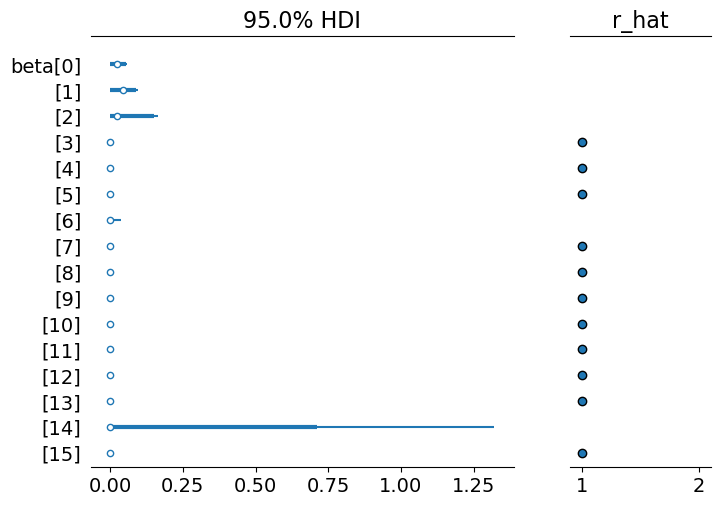

In [314]:
az.plot_forest(inference_results, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

### Effective Sample Size

Interpretation: 
- Low ESS:
    - A low ESS suggests that the samples might be correlated or that the sampler is struggling to explore the parameter space efficiently.
    - This can lead to less reliable inference results.
- High ESS:
    - A high ESS indicates that the samples are more independent, providing a more accurate representation of the posterior distribution.
    - This means that the information in your posterior distribution is well-represented by the samples.
    
Factors Affecting ESS:
- Model Complexity:
    - More complex models can lead to lower ESS.
- Sampling Algorithm:
    - The choice of MCMC algorithm can affect ESS.
    - Some algorithms might be more efficient in certain situations.
- Number of Samples:
    - Increasing the number of samples can generally improve ESS, but there's a trade-off with computational cost.
    
Typical Range:
- While there's no strict threshold for a "good" ESS, values significantly lower than the number of samples can be a cause for concern.
- A general rule of thumb is that the ESS should be at least 100 for reliable inference.
- However, this can vary depending on the specific context and the complexity of the model.

Bulk vs Tail ESS: 
- ESS Bulk:
    - This refers to the effective sample size (ESS) of the bulk of the posterior distribution.
    - It's a measure of how many independent draws the MCMC sampler has effectively produced.
- ESS Tail:
    - This refers to the ESS of the tails of the posterior distribution.
    - It's a measure of how well the sampler has explored the extreme values of the distribution.
    
- Values: 
    - Ideally, the ESS bulk and tail should be similar in magnitude.
    - A large difference between the two can indicate potential convergence issues or an insufficient number of samples.
    - If the ESS tail is significantly smaller than the ESS bulk, it suggests that the sampler may not have adequately explored the tails of the distribution.
- Shape:
    - Symmetrical:
        - If the posterior is roughly symmetrical, it suggests that the data is providing strong evidence for a particular range of parameter values.
    - Skewed:
        - A skewed posterior indicates that the data favors one tail of the distribution over the other.
        - This could be due to factors like outliers or non-linear relationships.
    - Multimodal:
        - A multimodal posterior suggests that the data supports multiple plausible parameter values.
        - This could be due to model misspecification or the presence of multiple local optima.  

Improving ESS:

- Increase the Number of Samples:
    - Run the MCMC sampler for longer.
- Consider a Different Sampler:
    - Experiment with different MCMC algorithms.
- Reparameterize the Model:
    - If possible, reparameterize the model to improve mixing.

In [315]:
def plot_ess(summary_df, variables, states):
    for i, var_name in enumerate(['beta', 'beta_raw', 'ind', 'mu']):
        pattern = f'{var_name}\[(\d+)\]'

        filtered_df = summary_df[summary_df.index.str.match(pattern)]
        
        fig, ax = plt.subplots(figsize=(20, 5), nrows=2, ncols=1, sharex=True)
        fig.suptitle(f"ESS bulk and tail: {var_name}")
            
        if var_name in ['beta', 'beta_raw', 'ind']:
            ax[0].plot(variables, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(variables, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=90)
            plt.show()
            
        else: 
            ax[0].plot(states, filtered_df['ess_bulk'])
            ax[0].set_title("ess bulk")
            ax[1].plot(states, filtered_df['ess_tail'])
            ax[0].set_title("ess tail")
            # plt.xlim(0, len(filtered_df['ess_bulk']))

            plt.xticks(rotation=45)
            plt.show() 

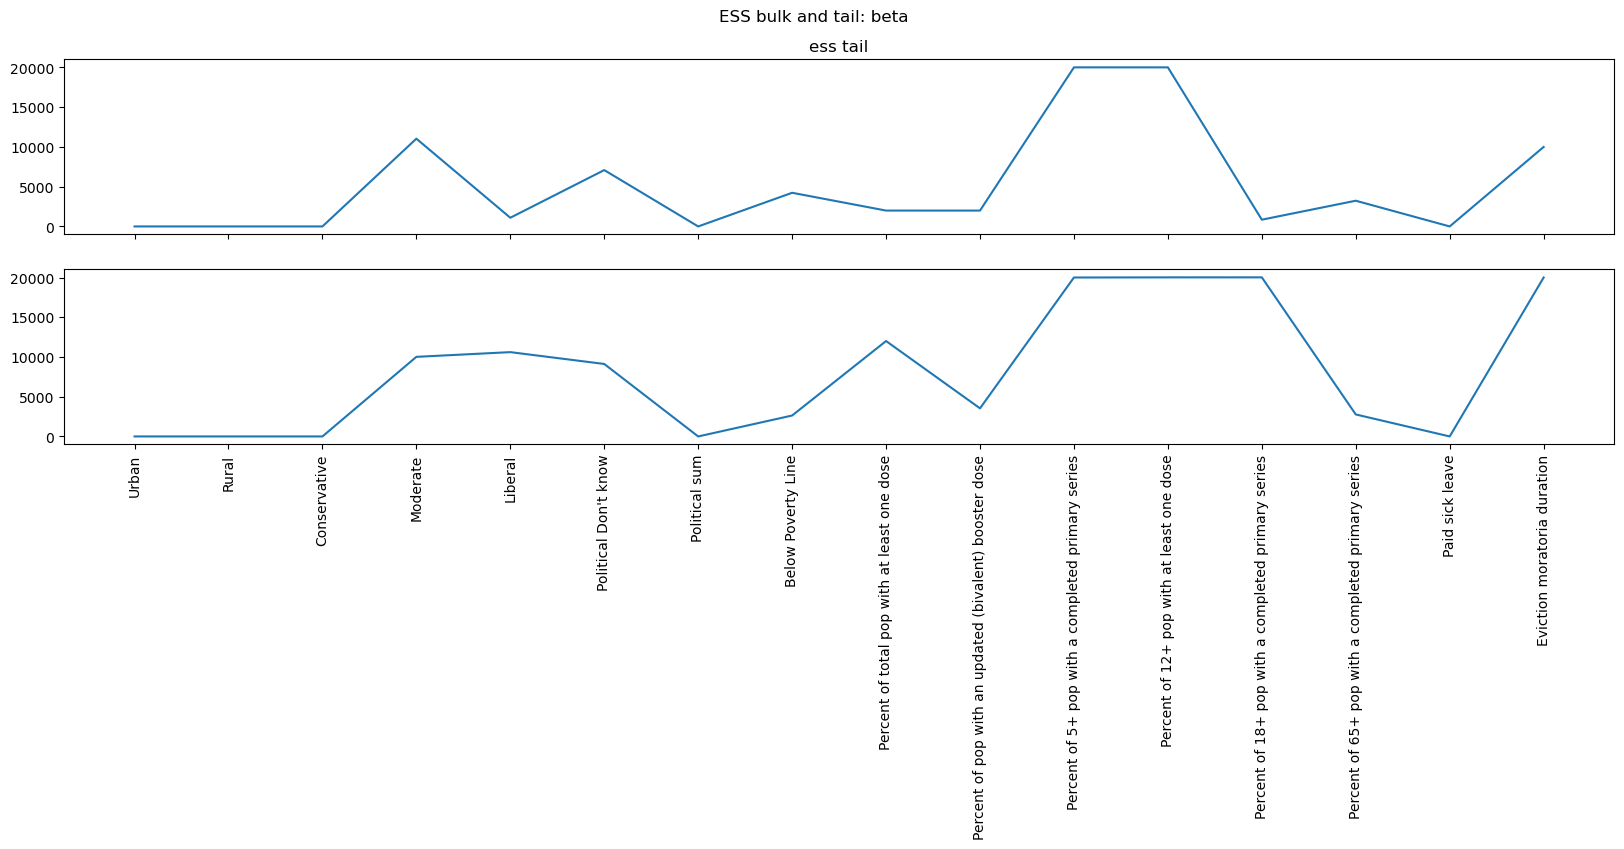

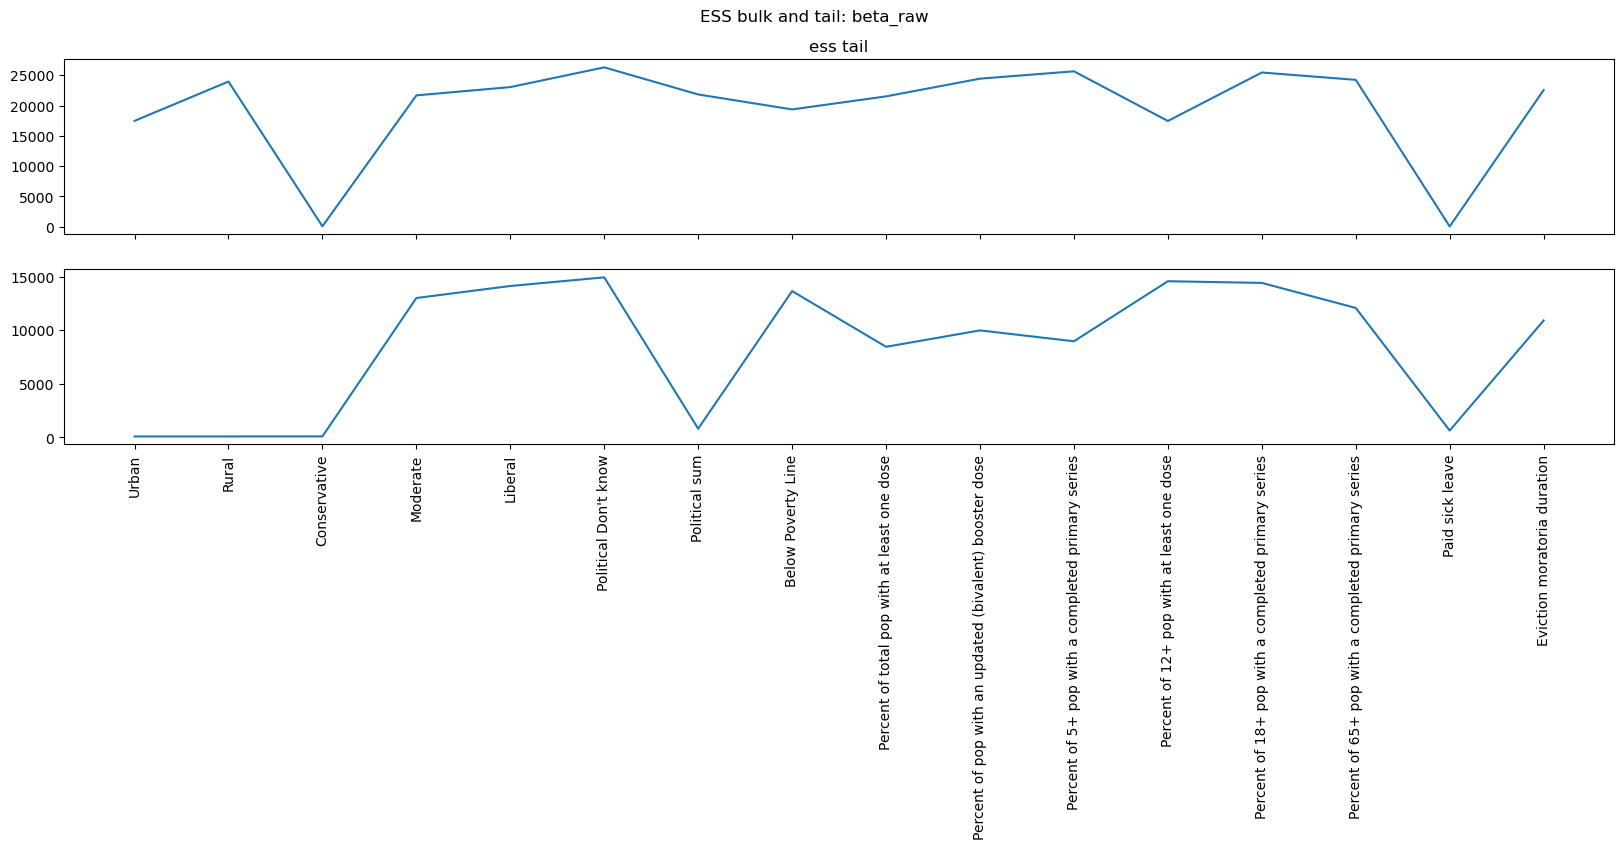

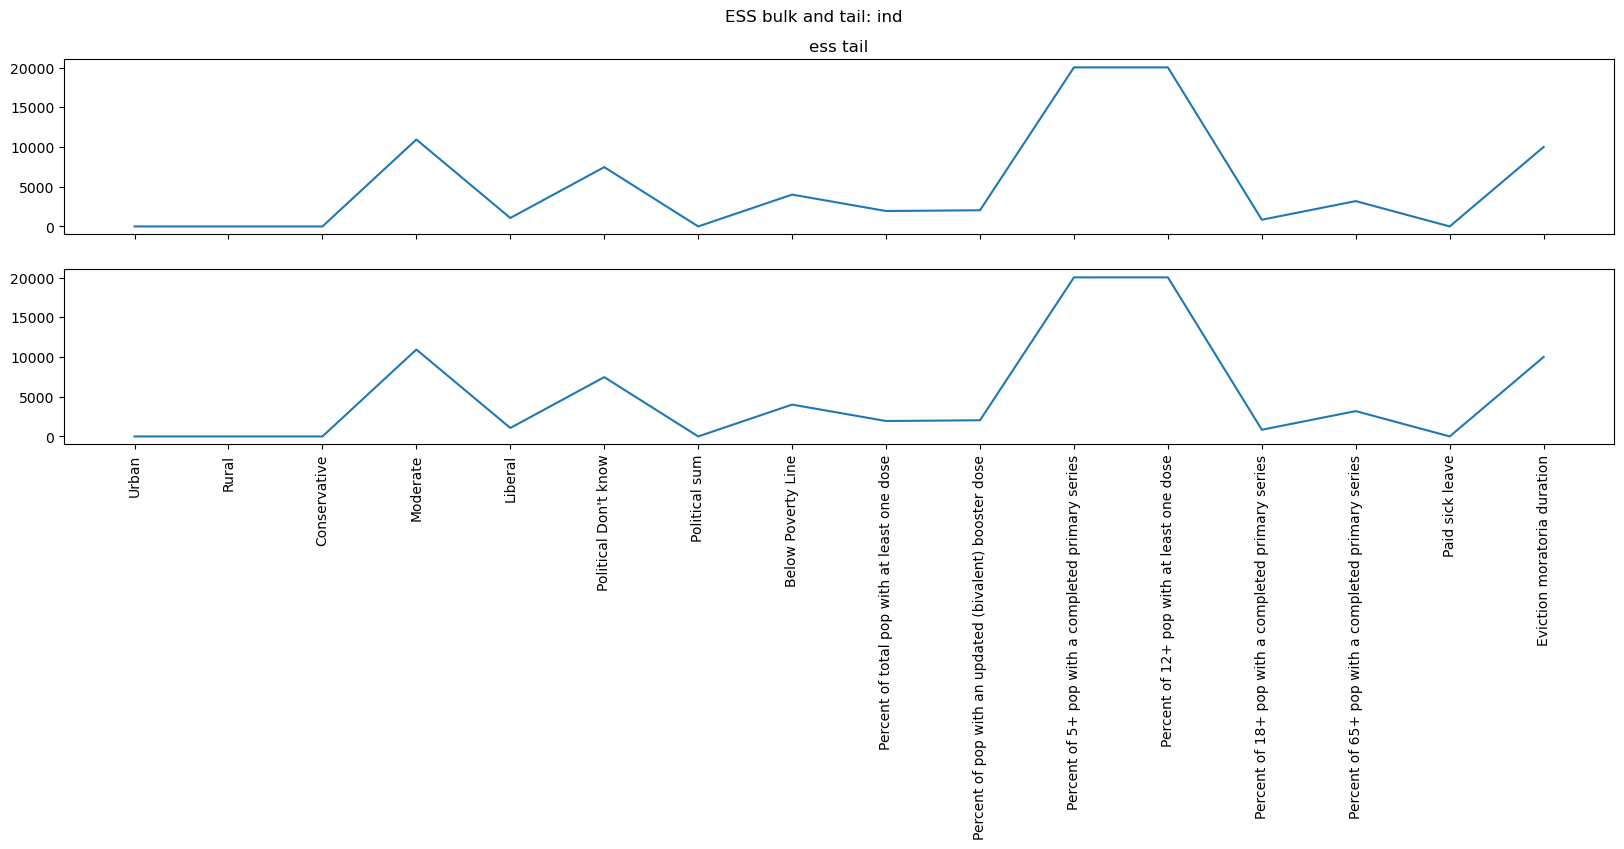

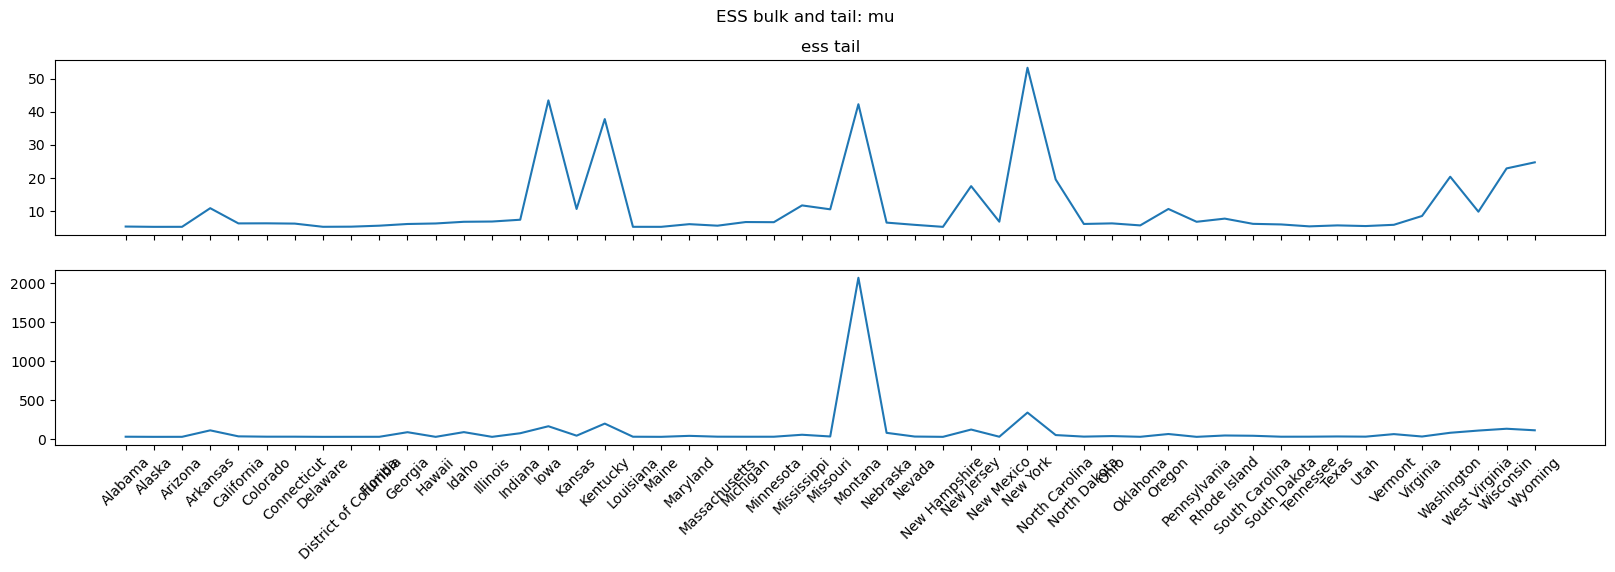

In [316]:
# Arviz method
# az.plot_ess(inference_results)
plot_ess(summary_df, inference_variables, inference_states)

### Trace Plots


- Density Plot:
    - Shape:
        - A symmetric, unimodal distribution indicates a well-defined posterior.
        - A skewed or multimodal distribution might suggest issues with the model or data.
    - Location:
        - The location of the peak indicates the most probable value of the parameter.
    - Spread:
        - The width of the distribution indicates the uncertainty around the parameter.
- Trace Plot:
    - Mixing:
        - The trace plot should show a well-mixed chain, meaning the sampler is exploring the parameter space effectively.
        - If the trace is stuck in a particular region, it might indicate convergence issues.
    - Stationarity:
        - The trace should appear stationary, meaning there are no clear trends or patterns over time.
        - A non-stationary trace might suggest that the sampler hasn't converged yet.
        
- Interpretation the Variables:
    - Beta:
        - The posterior distribution of beta indicates the importance of the corresponding features in the model.
        - A wider distribution suggests more uncertainty about the feature's importance.
        - Negative values indicate inverse relationships.
    - Beta_raw:
        - This represents the raw coefficients before feature selection.
        - A wider distribution might indicate that the feature is not strongly associated with the target variable.
    - Sigma:
        - The posterior distribution of sigma represents the uncertainty in the model's noise term.
        - A wider distribution indicates greater uncertainty.
        - Standard deviation of the noise term. A smaller value indicates less noise.
    - Ind:
        - The posterior distribution of ind represents the probability of each feature being included in the model.
        - A higher probability indicates a more important feature.
        - Indicator variables indicate whether a feature is included (1) or excluded (0) in the model.
    - Mu:
        - The posterior distribution of mu represents the uncertainty in the model's predictions.
        - Predicted mean values for the target variable.
    - Divergence:
        - Look for signs of divergence, such as sudden jumps in the trace plots or high R-hat values.

C:\Users\ashle\anaconda3\Lib\site-packages\arviz\stats\density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


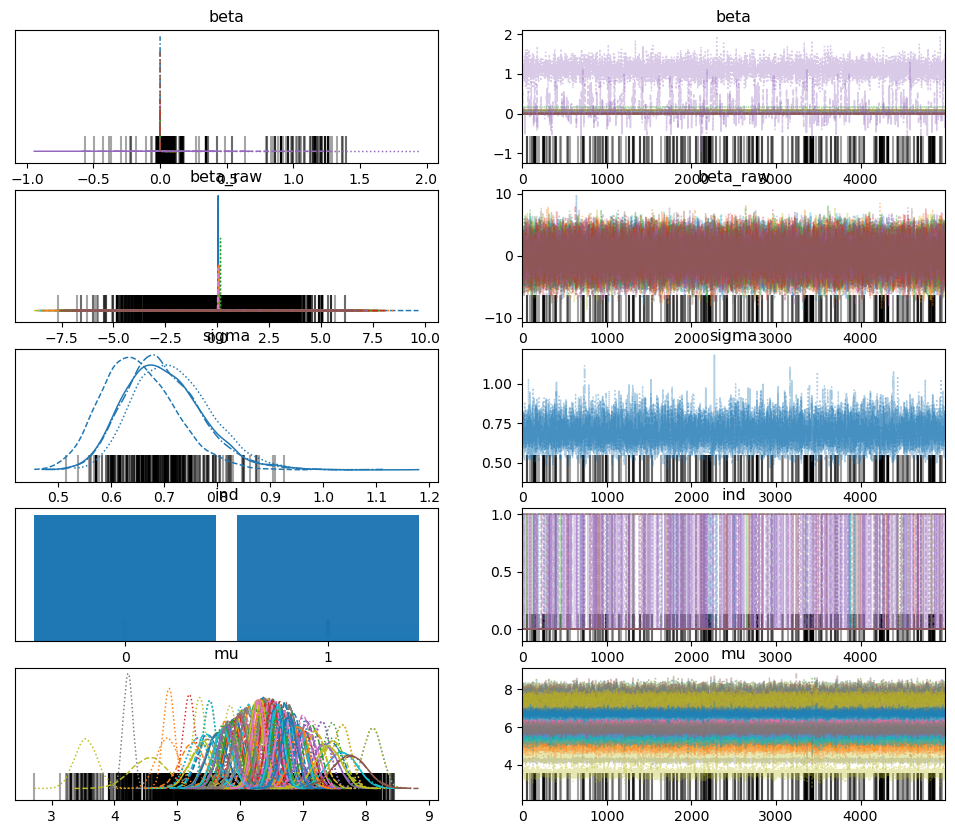

In [317]:
# Arviz method
# Left column are density plots which show the distribution of the parameter values.
# Right is the Trace Plot which plots the parameter values across MCMC iterations.
az.plot_trace(inference_results, var_names=["beta", "beta_raw", "sigma", "ind", "mu"]);

In [318]:
# def plot_result(
#     summary_df,
#     inference_variables, 
#     idx_pattern = r'beta\[(\d+)\]'
# ):
#     results = summary_df[summary_df.index.str.match(idx_pattern, regex=True)]
#     plt.plot(results, inference_variables)
#     plt.xticks(rotation=90)

#     plt.show()

### Posterior Distrubitions

In [319]:
# az.plot_posterior(inference_results)

### Model Fit

In [320]:
# # Log liklihood not in inference results. Need to add
# waic_score = az.waic(inference_results)  
# print(waic_score)

# loo_score = az.loo(inference_results)
# print(loo_score)

# ppc = az.from_pymc3(pm.sample_posterior_predictive(model, posterior_samples))


### Importance: np.abs(beta_means) * ind_means

- What is it? 
    - The importance variable typically represents a measure of the relative influence of different variables on a target variable in a Bayesian model.
    - It is often calculated by combining the posterior means of the coefficients (beta) with the inclusion probabilities (ind).
    - A higher importance value suggests that a variable is more likely to be influential in predicting the target variable.
    - The specific parameters that go into calculating importance can vary depending on the exact implementation, but generally include:
        - Posterior means of coefficients (beta): These represent the estimated effects of each variable on the target variable.
        - Inclusion probabilities (ind): These represent the probability that each variable is included in the model based on the posterior distribution.
- Notes: 
    - The importance metric is a relative measure and doesn't provide absolute values of effect size.
    - The typical range of values for the importance metric in Bayesian variable selection can vary widely depending on the specific problem, model complexity, and scale of the data.
    - Factors affecting the range:
        - Model complexity: More complex models with many variables and interactions might result in a wider range of importance values.
        - Data scale: The scale of the variables in the data can affect the scale of the coefficients and inclusion probabilities, which in turn affects the importance values.
        - Prior distributions: The choice of prior distributions for the coefficients and inclusion probabilities can influence the range of possible values.
- Higher values:
    - Variables with higher importance values are generally considered more influential in predicting the target variable.
    - This suggests that they have a stronger relationship with the outcome.
    - Variables with high importance might still have some degree of uncertainty associated with their effects, which can be assessed by examining the posterior distributions of their coefficients.
- Lower values:
    - Variables with lower importance values are less influential.
    - They might have weaker relationships or be less informative for predicting the target.
- Zero values:
    - Variables with an importance of zero are effectively excluded from the model, indicating that they have no significant impact on the target variable.

In [321]:
def plot_importance(importance, x_labels, importance_type):
    plt.plot(importance, 'o')
    plt.suptitle(f"{importance_type}")
    plt.xlabel(x_labels)
    plt.xticks(range(len(importance)), x_labels, rotation=90)
    plt.show()

#### Calculate feature importance based on coefficient magnitude and inclusion probability

In [322]:
# posterior_means = az.summary(inference_results)['mean']
posterior_means = summary_df['mean']
posterior_std = summary_df['sd']

beta_means = posterior_means.loc[
    posterior_means.index.str.startswith('beta') & ~posterior_means.index.str.startswith('beta_raw')
]

beta_std = posterior_std.loc[
    posterior_std.index.str.startswith('beta') & ~posterior_std.index.str.startswith('beta_raw')
]

ind_means = posterior_means.loc[posterior_means.index.str.startswith('ind')]


In [323]:
importance_1 = np.multiply(ind_means.values.flatten(), np.abs(beta_means.values).flatten())

# Normalize importance from 0-1. Is this necessary?
normalized_importance_1 = (importance_1 - importance_1.min()) / (importance_1.max() - importance_1.min())

# importance

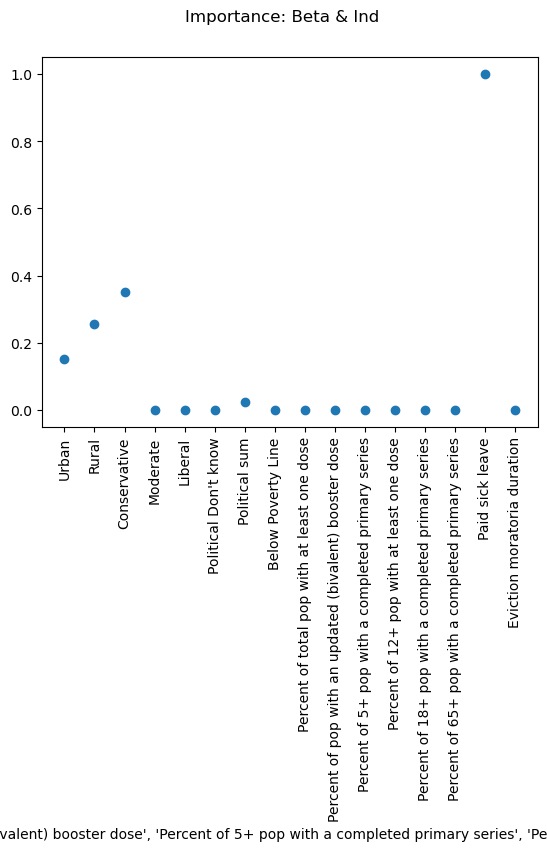

In [324]:
x_labels = list(df_variables.columns)

plot_importance(normalized_importance_1, x_labels, importance_type="Importance: Beta & Ind")

#### Calculate feature importance based on coefficient variance

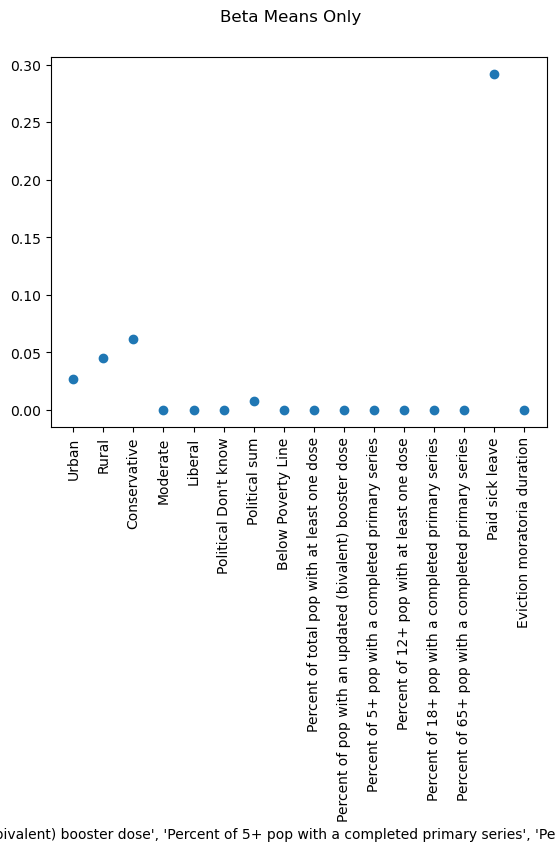

In [325]:
plot_importance(beta_means, x_labels, importance_type="Beta Means Only")

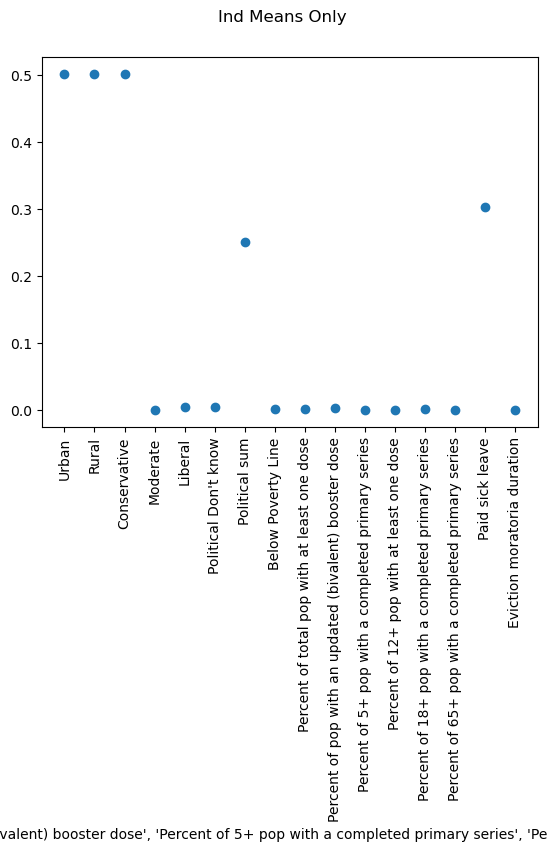

In [326]:
plot_importance(ind_means, x_labels, importance_type="Ind Means Only")